In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.optimizers import Adam
from keras.models import load_model

In [2]:
df = pd.read_csv('paris_temperature.csv')

In [3]:
df.describe()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
count,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,...,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000
mean,16.802356,10.096859,13.279319,16.541623,8.974869,12.624346,8.784293,76.118586,2.053552,71.432461,...,18.495550,209.079843,1013.928796,79.876178,19.180628,49.813874,4.296335,2.913613,10.746073,0.481990
std,6.840083,5.057506,5.819955,7.388110,6.197290,6.674208,4.779705,10.214621,3.939574,44.425978,...,6.069653,87.970190,10.349025,19.049478,4.334291,37.130885,3.214728,2.267046,5.473000,0.289633
min,-1.300000,-4.100000,-1.800000,-5.500000,-7.300000,-6.300000,-6.100000,51.600000,0.000000,0.000000,...,6.800000,0.400000,979.700000,13.000000,5.100000,0.000000,0.000000,0.000000,10.000000,0.000000
25%,11.800000,6.625000,9.300000,11.800000,4.600000,8.025000,6.200000,68.600000,0.000000,0.000000,...,13.900000,180.750000,1008.900000,71.200000,16.800000,16.825000,1.400000,1.000000,10.000000,0.242500
50%,16.150000,10.200000,13.050000,16.150000,10.200000,13.050000,9.150000,76.750000,0.195000,100.000000,...,17.850000,222.000000,1014.650000,85.600000,20.300000,43.500000,3.800000,2.000000,10.000000,0.480000
75%,21.850000,13.600000,17.575000,21.850000,13.600000,17.575000,12.175000,84.475000,2.143000,100.000000,...,21.975000,265.675000,1019.900000,94.075000,22.100000,76.325000,6.500000,4.000000,10.000000,0.750000
max,36.200000,21.200000,28.300000,39.000000,21.200000,29.600000,20.300000,95.000000,25.008000,100.000000,...,44.300000,358.200000,1042.800000,100.000000,39.100000,169.800000,14.700000,8.000000,75.000000,0.980000


In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Quesion 1

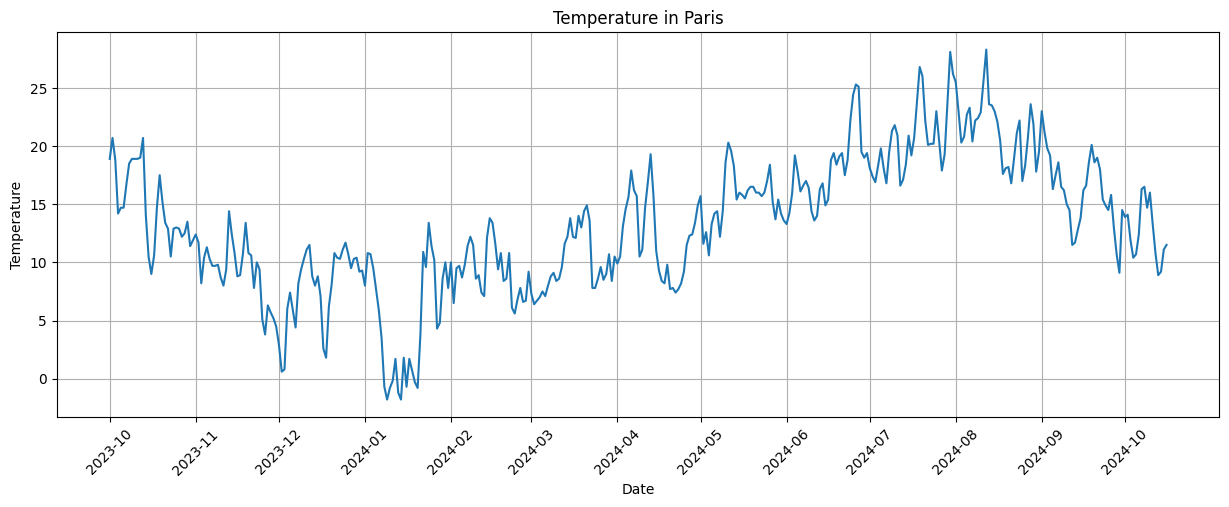

In [5]:

plt.figure(figsize=(15, 5))
plt.plot(df.index, df['temp'])
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature in Paris")
plt.xticks(pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS').to_pydatetime(), [date.strftime('%Y-%m') for date in pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')], rotation=45)
plt.grid()
plt.show()

# Question 2

In [6]:
numerical_features = []
categorical_features = []
date_features = []
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        numerical_features.append(col)
    elif df[col].dtype == 'object':
        categorical_features.append(col)
    else:
        numerical_features.append(col)

print(f"There are {len(numerical_features)} numerical features: {numerical_features}")
print(f"There are {len(categorical_features)} categorical features: {categorical_features}")

There are 24 numerical features: ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'moonphase']
There are 8 categorical features: ['name', 'preciptype', 'sunrise', 'sunset', 'conditions', 'description', 'icon', 'stations']


In [7]:
df_numerical = df[numerical_features]
df_numerical

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
datetime,,,,,,,,,,,,,,,,,,,,,
2023-10-01,26.5,12.5,18.9,26.5,12.5,18.9,13.7,74.3,0.144,100.0,...,11.3,170.2,1023.7,46.5,18.6,39.8,3.5,3,10,0.57
2023-10-02,27.7,14.5,20.7,27.9,14.5,20.7,14.7,71.0,0.000,0.0,...,12.0,173.7,1018.8,48.6,16.8,51.3,4.4,4,10,0.60
2023-10-03,22.1,15.0,18.8,22.1,15.0,18.8,13.0,69.9,0.386,100.0,...,22.8,277.2,1020.5,71.8,22.1,54.5,4.8,4,10,0.63
2023-10-04,18.2,10.2,14.2,18.2,10.2,14.2,9.3,73.2,0.006,100.0,...,12.3,260.9,1029.8,62.0,22.4,58.9,5.1,4,10,0.66
2023-10-05,19.8,11.0,14.7,19.8,11.0,14.7,9.4,72.1,0.014,100.0,...,6.8,238.3,1027.3,82.3,21.3,41.7,3.5,3,10,0.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-12,13.5,8.1,10.8,13.5,6.6,10.3,2.7,58.9,0.000,45.2,...,13.6,223.4,1015.2,70.4,24.1,87.0,7.8,3,10,0.33
2024-10-13,11.2,7.8,8.9,11.2,4.9,6.8,4.6,75.5,3.200,38.7,...,22.0,20.7,1014.8,99.8,22.5,5.0,0.6,0,10,0.36
2024-10-14,9.9,8.0,9.2,8.9,6.1,7.8,7.3,88.1,1.100,32.3,...,14.0,278.9,1009.7,100.0,24.1,7.1,0.6,0,10,0.40


# Question 4

C:\Users\ADM\AppData\Local\Temp\ipykernel_11808\2806927300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numerical[numerical_features] = scaler.fit_transform(df_numerical[numerical_features])


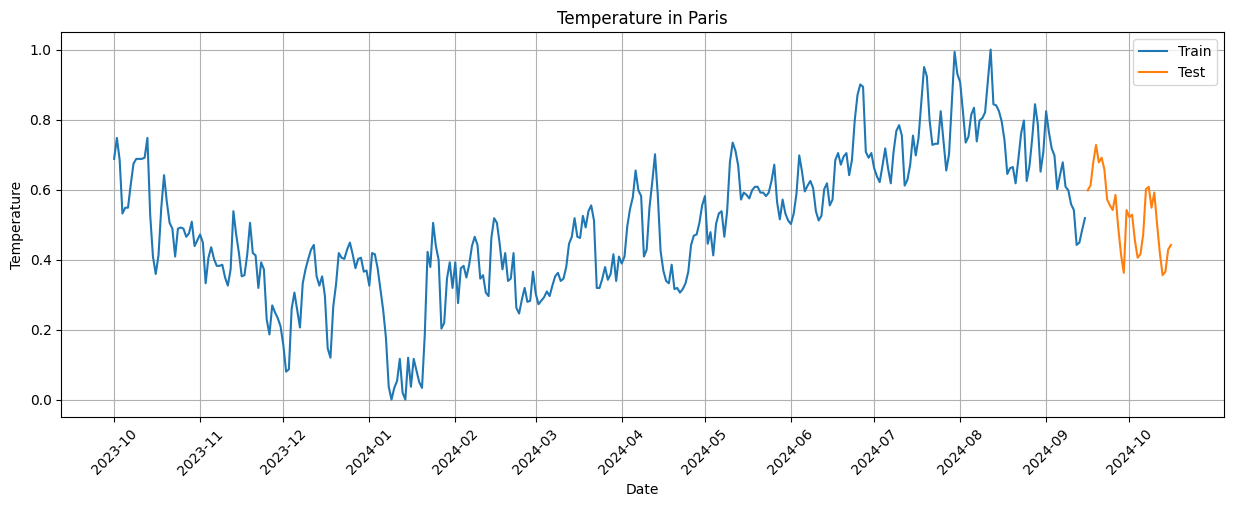

In [8]:
scaler = MinMaxScaler()
df_numerical[numerical_features] = scaler.fit_transform(df_numerical[numerical_features])
train_set = df_numerical[df_numerical.index <= pd.Timestamp('2024-09-15')]
test_set = df_numerical[df_numerical.index > pd.Timestamp('2024-09-15')]
plt.figure(figsize=(15, 5))
plt.plot(train_set.index, train_set['temp'], label='Train')
plt.plot(test_set.index, test_set['temp'], label='Test')
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature in Paris")
plt.xticks(pd.date_range(start=df_numerical.index.min(), end=df_numerical.index.max(), freq='MS').to_pydatetime(), [date.strftime('%Y-%m') for date in pd.date_range(start=df_numerical.index.min(), end=df_numerical.index.max(), freq='MS')], rotation=45)
plt.grid()
plt.legend()
plt.show()

# Question 7
### (a) Applying LSTM model

In [9]:
def create_features_and_labels(data, feature_columns, target_column, window=1):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[feature_columns].iloc[i:i + window].values)
        y.append(data[target_column].iloc[i + window])
    return np.array(X), np.array(y)

feature_columns = numerical_features
target_column = 'temp'  
window_size = 4

X_train, y_train = create_features_and_labels(train_set, feature_columns, target_column, window=window_size)
X_test, y_test = create_features_and_labels(test_set, feature_columns, target_column, window=window_size)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (347, 4, 24)
y_train shape: (347,)
X_test shape: (27, 4, 24)
y_test shape: (27,)


In [10]:
# stop here!

In [ ]:
optimizer = Adam(learning_rate=5e-3)
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.4))
model.add(Dense(50, activation='relu', kernel_regularizer='l2'))
model.add(Dense(1))
model.compile(optimizer=optimizer, loss='mean_squared_error')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_2.keras', save_best_only=True, monitor='val_loss', verbose=1)
history = model.fit(X_train, y_train, batch_size=4, epochs=300, validation_data=(X_test, y_test), callbacks=[reduce_lr, early_stopping,model_checkpoint], verbose=1)

Epoch 1/300


C:\Users\ADM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4279
Epoch 1: val_loss improved from inf to 0.03701, saving model to best_model_2.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.3991 - val_loss: 0.0370 - learning_rate: 0.0050
Epoch 2/300
75/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0310
Epoch 2: val_loss improved from 0.03701 to 0.01347, saving model to best_model_2.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0302 - val_loss: 0.0135 - learning_rate: 0.0050
Epoch 3/300
80/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0153
Epoch 3: val_loss did not improve from 0.01347
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0152 - val_loss: 0.0237 - learning_rate: 0.0050
Epoch 4/300
74/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0144
Epoch 4: val_loss improved from 0.01347 to 0.00772, saving model to best_model_2.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0143 - val_loss: 0.0077 - learning_rate: 0.0050
Epoch 5/300
84/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

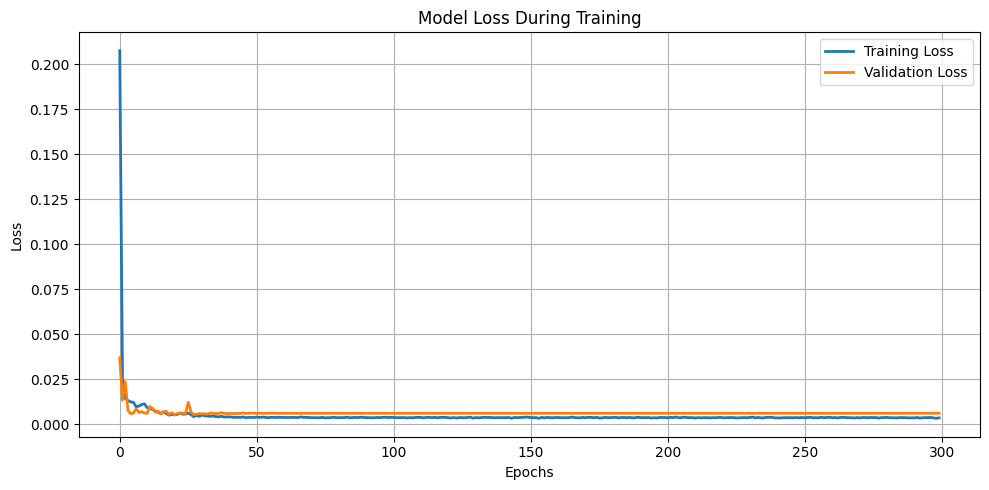

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
RMSE: 3.4228
MAE: 2.7071


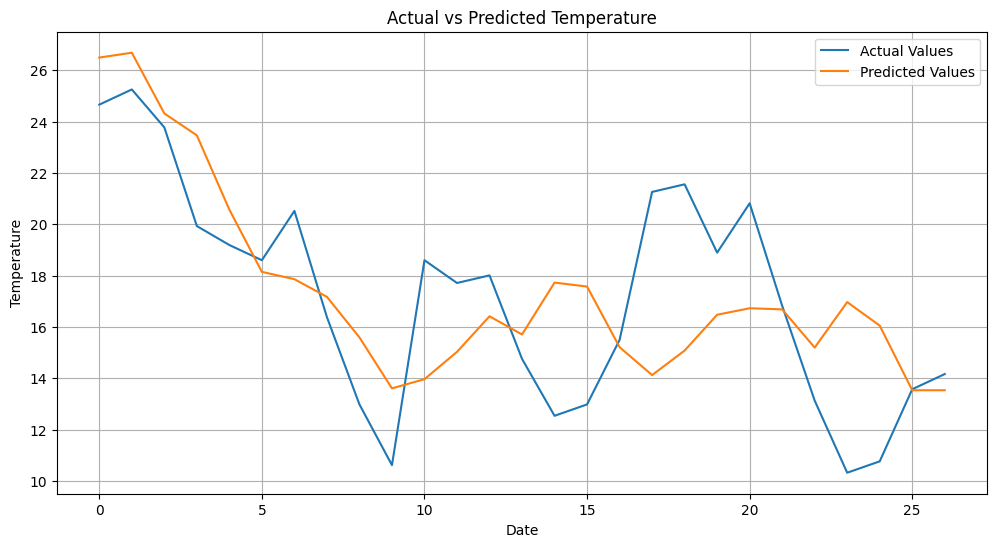

In [25]:
y_pred = model.predict(X_test)
scaler_temp = MinMaxScaler()
scaler_temp.min_, scaler_temp.scale_ = scaler.min_[df.columns.get_loc('temp')], scaler.scale_[df.columns.get_loc('temp')]
y_test_original = scaler_temp.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = scaler_temp.inverse_transform(y_pred).flatten()
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Actual Values")
plt.plot(y_pred_original, label="Predicted Values")
plt.title("Actual vs Predicted Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.show()